In [1]:
import os
import re
import _pickle as cPickle
from collections import OrderedDict, defaultdict, Counter

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import pdb
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from scipy.sparse import csr_matrix
import nltk
from nltk import word_tokenize

import multiprocessing

from data_structure import Instance

np.random.seed(1234)
random.seed(1234)

pd.set_option('display.max_rows', 2000)

# configure

In [246]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)

del_all_flags(tf.flags.FLAGS)

flags = tf.app.flags

flags.DEFINE_string('train_dir', 'data/yelp/train', 'path of train data')
flags.DEFINE_string('val_dir', 'data/yelp/val', 'path of val data')
flags.DEFINE_string('test_dir', 'data/yelp/test', 'path of test data')
flags.DEFINE_integer('batch_l', 8, 'batch length')

flags.DEFINE_string('stopwords_path', 'data/stopwords_mallet.txt', 'path of input data')

flags.DEFINE_string('business_path', 'data/yelp/business.json', 'path of business metadata')
flags.DEFINE_string('ref_path', 'data/yelp/references.csv', 'directory of ref summaries')
flags.DEFINE_string('output_path', 'data/yelp/instances.pkl', 'path of output data')
flags.DEFINE_string('output_small_path', 'data/yelp/instances_small.pkl', 'path of output data')
flags.DEFINE_string('output_large_path', 'data/yelp/instances_large.pkl', 'path of output data')

flags.DEFINE_integer('n_vocab', 50000, 'size of vocab')

flags.DEFINE_string('f', '', 'kernel')

config = flags.FLAGS

In [3]:
# special tokens
PAD = '<pad>' # This has a vocab id, which is used to pad the encoder input, decoder input and target sequence
UNK = '<unk>' # This has a vocab id, which is used to represent out-of-vocabulary words
BOS = '<p>' # This has a vocab id, which is used at the beginning of every decoder input sequence
EOS = '</p>' # This has a vocab id, which is used at the end of untruncated target sequences
dummy_tokens = [PAD, UNK, BOS, EOS]

In [4]:
def apply_parallel(datas, num_split, map_func):
    p = multiprocessing.Pool(processes=num_split)
    data_split = np.array_split(datas, num_split)
    output_dfs = p.map(map_func, data_split)
    p.close()
    output_df = pd.concat(output_dfs)
    return output_df

# load source

## load metadata

In [5]:
def get_business_df(business_path):
    f = open(business_path, 'r')
    business_df = pd.read_json(f, lines=True)
    f.close()
    business_df['category_list'] = business_df['categories'].apply(lambda categories: categories.split(', ') if categories is not None else [])
    return business_df

In [6]:
business_df = get_business_df(config.business_path)

In [7]:
# confirm data
def get_category_cnt(business_df):
    return pd.DataFrame.from_dict(Counter([category for category_list in business_df['category_list'] for category in category_list]), orient='index').sort_values(0, ascending=False)

In [9]:
# get_category_cnt(business_df)

In [10]:
# filtered_df = business_df[business_df['category_list'].apply(lambda category_list: 'Restaurants' in category_list)]
# get_category_cnt(filtered_df)

## load review raw data

In [11]:
def get_tokens(text):
    def preprocess(text):
        text = text.lower()
        text = re.sub(r'[0-9]+.[0-9]+|[0-9]+,[0-9]+|[0-9]+', '#', text)
        text = re.sub('-', ' ', text)
        code_regex = re.compile('["\%&\\\\\()*+/:;<=>?@[\\]^_`{|}~「」〔〕“”〈〉『』【】＆＊・（）＄＠。、？！｀＋￥％]|-lrb-(.*?)-rrb-|-lsb-(.*?)-rsb-')
        text = code_regex.sub('', text)
        return text

    tokenize = lambda lines: [word_tokenize(line) for line in lines]
    filtering = lambda tokens: [line_tokens for line_tokens in tokens if len(line_tokens) > 2]

    preprocessed_text = preprocess(text)
    lines = [line.strip() for line in re.split('[.!]', preprocessed_text) if not line == '']
    tokens = tokenize(lines)
    tokens = filtering(tokens)
    return tokens

In [12]:
def get_data_raw_df(data_paths):
    data_raw_dfs = []
    for data_path in data_paths:
        f = open(data_path, 'r')
        item_raw_df = pd.read_json(f)
        f.close()
        data_raw_dfs.append(item_raw_df)
    data_raw_df = pd.concat(data_raw_dfs)
    data_raw_df['tokens'] = data_raw_df['text'].apply(get_tokens)
    data_raw_df = data_raw_df[data_raw_df['tokens'].apply(lambda tokens: len(tokens) > 2)]
    return data_raw_df

In [13]:
get_data_paths = lambda data_dir: [os.path.join(data_dir, data_name) for data_name in os.listdir(data_dir) if not data_name == 'store-to-nreviews.json']
train_data_paths = get_data_paths(config.train_dir)
val_data_paths = get_data_paths(config.val_dir)
test_data_paths = get_data_paths(config.test_dir)

## get train & val raw data

In [14]:
%%time
train_raw_df = apply_parallel(train_data_paths, num_split=32, map_func=get_data_raw_df).reset_index()

CPU times: user 40 s, sys: 15.1 s, total: 55.1 s
Wall time: 2min 5s


In [15]:
%%time
val_raw_df = apply_parallel(val_data_paths, num_split=8, map_func=get_data_raw_df).reset_index()

CPU times: user 8.24 s, sys: 7.01 s, total: 15.2 s
Wall time: 47.2 s


In [16]:
sum(train_raw_df.tokens.apply(lambda tokens: len(tokens)==0))

0

le est sympathique et les prix sont raisonnables sum la dim de san ayce

## get test raw data

In [17]:
%%time
test_tmp_df = apply_parallel(test_data_paths, num_split=8, map_func=get_data_raw_df).reset_index()

CPU times: user 2.83 s, sys: 4.3 s, total: 7.12 s
Wall time: 40.3 s


In [18]:
def get_test_raw_df(ref_path, train_raw_df, val_raw_df, test_raw_df, business_df):
    def get_review_business_id_dict(ref_df, train_raw_df, val_raw_df, test_raw_df):
        ref_review_ids = []
        for _, row in ref_df.iterrows():
            ref_review_ids += [row['Input.original_review_%i_id' % i] for i in range(config.batch_l)]
        ref_review_id_df = pd.DataFrame(ref_review_ids, columns=['review_id']) # only review_id in reference.csv
        concat_raw_df = pd.concat([train_raw_df, val_raw_df, test_raw_df])[['review_id', 'business_id']] # filter review_id and business_id pair
        review_business_id_dict = {row.review_id: row.business_id for _, row in pd.merge(ref_review_id_df, concat_raw_df).iterrows()}
        return review_business_id_dict
    
    ref_df = pd.read_csv(open(ref_path, 'r'))
    ref_df['business_id_csv'] = ref_df.apply(lambda row: row['Input.business_id'] if row['Input.business_id'] != '#NAME?' else 'null_%i' % row.name, axis=1)
    review_business_id_dict = get_review_business_id_dict(ref_df, train_raw_df, val_raw_df, test_raw_df)
    
    test_raw_dfs = []
    for index, row in ref_df.iterrows():
        business_id = None 
        texts, review_ids = [], []
        summary = row['Answer.summary']
        for i in range(config.batch_l):
            text = row['Input.original_review_%i' % i]
            review_id = row['Input.original_review_%i_id' % i]
            texts.append(text)
            review_ids.append(review_id)
            if review_id == '#NAME?': review_id = None
            if business_id is None and review_id in review_business_id_dict: business_id = review_business_id_dict[review_id] # get business_id from review_business_id_dict
        
        if business_id is None: business_id = row['business_id_csv'] # if all review_id not in review_business_id_dict, then business_id in csv is used
        for text, review_id in zip(texts, review_ids):
            test_raw_dfs.append({'business_id': business_id, 'text': text, 'review_id': review_id, 'summary': summary})
        
    test_raw_df = pd.DataFrame(test_raw_dfs)
    test_raw_df['tokens'] = test_raw_df['text'].apply(get_tokens)
    return test_raw_df, ref_df

In [19]:
test_raw_df, ref_df = get_test_raw_df(config.ref_path, train_raw_df, val_raw_df, test_tmp_df, business_df)

# group data by business id

In [20]:
def filter_category(group_df, business_df):
    group_df = pd.merge(group_df, business_df[['business_id', 'category_list']])
    group_df = group_df[group_df['category_list'].apply(lambda category_list: 'Restaurants' in category_list)]
    return group_df

In [21]:
def get_test_group_df(data_df, business_df):
    group_df = data_df.groupby('business_id').agg({
        'tokens': lambda token_idxs_list: [sent_idxs for token_idxs in list(token_idxs_list) for sent_idxs in token_idxs],
        'summary': lambda summary_series: list(summary_series)[0] # only first column for each business id
    })
    group_df['doc_l'] = group_df['tokens'].apply(lambda tokens: len(tokens))
    group_df['max_sent_l'] = group_df['tokens'].apply(lambda tokens: max([len(line) for line in tokens]))
    group_df['sent_l'] = group_df['tokens'].apply(lambda tokens: [len(line) for line in tokens])
    group_df = group_df.reset_index()
    print('before filtering: %i' % len(group_df))
    group_df = filter_category(group_df, business_df)
    print('after filtering: %i' % len(group_df))
    return group_df

In [22]:
test_df = get_test_group_df(test_raw_df, business_df)

before filtering: 200
after filtering: 141


In [185]:
def get_group_df(data_df, business_df, test_df, filter_sent_l=np.inf, filter_doc_l=np.inf):
    group_df = data_df.groupby('business_id').agg({
        'tokens': lambda tokens_list: list(tokens_list)
    })
    test_business_ids = test_df['business_id'].values
    batch_list = []
    for business_id, row in group_df.iterrows():
        if business_id in test_business_ids: continue
        tokens = random.sample(row.tokens, len(row.tokens))
        tokens = [sents for sents in tokens if max([len(sent) for sent in sents]) <= filter_sent_l]
        tokens_list = list(zip(*[iter(tokens)]*config.batch_l))
        for tokens in tokens_list:
            tokens = [sent for sents in tokens for sent in sents]
            doc_l = len(tokens)
            sent_l = [len(sent) for sent in tokens]
            max_sent_l = max(sent_l)
            batch_list.append({'business_id': business_id, 'tokens': tokens, 'doc_l': doc_l, 'sent_l': sent_l, 'max_sent_l': max_sent_l})
    group_df = pd.DataFrame(batch_list)
    print('before filtering: %i' % len(group_df))
    group_df = group_df[group_df['doc_l'] <= filter_doc_l]
    group_df = filter_category(group_df, business_df)
    print('after filtering: %i' % len(group_df))
    return group_df

In [192]:
train_df = get_group_df(train_raw_df, business_df, test_df, filter_sent_l=50, filter_doc_l=50)
val_df = get_group_df(val_raw_df, business_df, test_df, filter_sent_l=50, filter_doc_l=50)

before filtering: 240433
after filtering: 160626
before filtering: 29917
after filtering: 20063


50 26
50 26
65 28


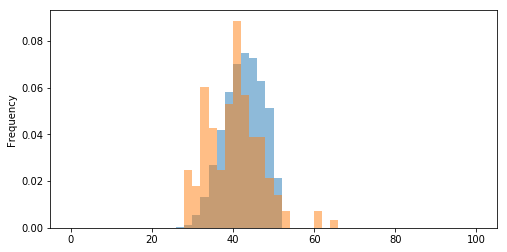

In [193]:
print(max(train_df.doc_l), min(train_df.doc_l))
print(max(val_df.doc_l), min(val_df.doc_l))
print(max(test_df.doc_l), min(test_df.doc_l))

train_df.doc_l.plot(bins=50, alpha=0.5, figsize=(8,4), kind='hist', range=(0, 100), density=True);
test_df.doc_l.plot(bins=50, alpha=0.5, figsize=(8,4), kind='hist', range=(0, 100), density=True);

50 13
50 14
129 18


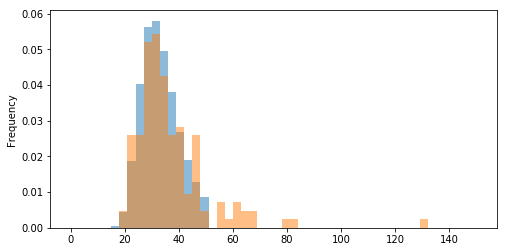

In [194]:
print(max(train_df.max_sent_l), min(train_df.max_sent_l))
print(max(val_df.max_sent_l), min(val_df.max_sent_l))
print(max(test_df.max_sent_l), min(test_df.max_sent_l))

train_df.max_sent_l.plot(bins=50, alpha=0.5, figsize=(8,4), kind='hist', range=(0, 150), density=True);
test_df.max_sent_l.plot(bins=50, alpha=0.5, figsize=(8,4), kind='hist', range=(0, 150), density=True);

# build token idxs for language modeling 

In [195]:
%%time
words_list = train_df['tokens'].apply(lambda tokens: [token for line in tokens for token in line])
word_tf_dict = sorted(Counter([word for words in words_list for word in words]).items(), key=lambda x: x[1])

CPU times: user 22.4 s, sys: 3 s, total: 25.4 s
Wall time: 25.2 s


In [196]:
%%time
unique_words_list = train_raw_df['tokens'].apply(lambda tokens: list(set([token for line in tokens for token in line])))
word_df_dict = sorted(Counter([word for unique_words in unique_words_list for word in unique_words]).items(), key=lambda x: x[1])

CPU times: user 40.5 s, sys: 4.69 s, total: 45.2 s
Wall time: 44.9 s


In [197]:
def filter_words(word_tf_dict, max_tf_rate=0., min_tf_rate=0., min_tf=None, min_df=None, stop_words=[]):
    filtered_word_tf_dict = dict(word_tf_dict[int(min_tf_rate*len(word_tf_dict)):int((1-max_tf_rate)*len(word_tf_dict))][::-1])
    if min_tf: filtered_word_tf_dict = {word: tf for word, tf in filtered_word_tf_dict.items() if tf >= min_tf}
    filtered_words = [word for word, _ in filtered_word_tf_dict.items() if word not in stop_words]
    
    if min_df: 
        filtered_df_words = [word for word, df in word_df_dict if df >= min_df]
        filtered_df_words = list(set(filtered_words) & set(filtered_df_words))
        filtered_word_tf_df_dict = sorted([(word, filtered_word_tf_dict[word]) for word in filtered_df_words], key=lambda x:x[1])[::-1]
        filtered_words = [word for word, _ in filtered_word_tf_df_dict]
        
    return filtered_words

In [249]:
lm_words = [PAD, UNK, BOS, EOS]
# lm_words += filter_words(word_tf_dict, min_tf=10) # large: 10 usual: 10 small: 20
lm_words += filter_words(word_tf_dict, min_tf=20) # large: 10 usual: 10 small: 20
idx_to_word = {idx: word for idx, word in enumerate(lm_words)}
word_to_idx = {word: idx for idx, word in idx_to_word.items()}
len(lm_words)

24425

In [250]:
def apply_token_idxs(tokens_series):
    def get_token_idxs(tokens):
        return [[word_to_idx[token] if token in word_to_idx else word_to_idx[UNK] for token in sent] for sent in tokens]
    return tokens_series.apply(get_token_idxs)

In [251]:
%%time
train_df['token_idxs'] = apply_parallel(train_df['tokens'], num_split=64, map_func=apply_token_idxs)

CPU times: user 54.4 s, sys: 1min 6s, total: 2min
Wall time: 2min 3s


In [252]:
%%time
val_df['token_idxs'] = apply_parallel(val_df['tokens'], num_split=64, map_func=apply_token_idxs)

CPU times: user 3.87 s, sys: 47.2 s, total: 51 s
Wall time: 51 s


In [253]:
test_df['token_idxs'] = apply_token_idxs(test_df['tokens'])

# build bow for topic modeling 

In [254]:
with open(config.stopwords_path, 'r') as f:
    stop_words_mallet = [w.replace('\n', '') for w in f.readlines()]
stop_words_nltk = nltk.corpus.stopwords.words('english')
# stop_words = list(set(stop_words_nltk + [',', '#', '$', "n't", "'s", "'ve", "'m",  "'ll", "'re", "'d", 'could', 'would', 'us', 'ca']))
stop_words = list(set(stop_words_mallet + stop_words_nltk + [',', '#', '$', "n't", "'s", "'ve", "'m",  "'ll", "'re", "'d", 'could', 'would', 'us', 'ca']))
# tm_words = filter_words(word_tf_dict, min_df=500, min_tf=10, stop_words=stop_words) # large: 500 usual: 1000 small: 2000
# tm_words = filter_words(word_tf_dict, min_df=1000, min_tf=10, stop_words=stop_words) # large: 500 usual: 1000 small: 2000
tm_words = filter_words(word_tf_dict, min_df=2000, min_tf=20, stop_words=stop_words) # large: 500 usual: 1000 small: 2000
# tm_words = filter_words(word_tf_dict, min_tf=1000, stop_words=stop_words)
word_to_bow = {word: idx for idx, word in enumerate(tm_words)}
bow_idxs = np.array([word_to_idx[word] for word in tm_words])
len(tm_words)

2721

In [255]:
def apply_bows(tokens_series):
    def get_bows(tokens):
        def line_to_bow(line):
            counter = Counter(line)
            bow = np.zeros(len(word_to_bow), dtype=np.int32)
            indices_cnts = np.array([[word_to_bow[word], cnt] for word, cnt in counter.items() if word in word_to_bow])
            if len(indices_cnts) > 0: bow[indices_cnts[:, 0]] = indices_cnts[:, 1]
            return bow
#         bows = np.array([line_to_bow(line) for line in tokens])
        bows = csr_matrix([line_to_bow(line) for line in tokens])
        return bows
    return tokens_series.apply(get_bows)

In [256]:
%%time
train_df['bows'] = apply_parallel(train_df['tokens'], num_split=64, map_func=apply_bows)

CPU times: user 28 s, sys: 1min 2s, total: 1min 30s
Wall time: 1min 34s


In [257]:
%%time
val_df['bows'] = apply_parallel(val_df['tokens'], num_split=32, map_func=apply_bows)

CPU times: user 3.26 s, sys: 31.4 s, total: 34.7 s
Wall time: 35.9 s


In [258]:
test_df['bows'] = apply_bows(test_df['tokens'])

In [259]:
#confirm
for i in range(len(val_df)//100):
    assert all([all([word in line for word in np.array(tm_words)[np.where(line_bows>0)[0]]]) for line_bows, line in zip(val_df['bows'].iloc[i*100].toarray(), val_df['tokens'].iloc[i*100])])

# write out

In [260]:
def get_save_df(data_df, frac=1., summary=False):
    save_df = data_df[['business_id', 'doc_l', 'sent_l', 'max_sent_l', 'bows', 'token_idxs']]
    if summary: save_df = data_df[['business_id', 'doc_l', 'sent_l', 'max_sent_l', 'bows', 'token_idxs', 'summary']]
    if frac < 1: save_df = save_df.sample(frac=0.01)
    return save_df

In [261]:
train_save_df = get_save_df(train_df)
val_save_df = get_save_df(val_df, frac=0.01)
test_save_df = get_save_df(test_df, summary=True)
len(train_save_df), len(val_save_df), len(test_save_df)

(160626, 201, 141)

In [262]:
print('saving preprocessed instances...')
# cPickle.dump((train_save_df, val_save_df, test_save_df, word_to_idx, idx_to_word, bow_idxs),open(config.output_large_path,'wb'))
# cPickle.dump((train_save_df, val_save_df, test_save_df, word_to_idx, idx_to_word, bow_idxs),open(config.output_path,'wb'))
cPickle.dump((train_save_df, val_save_df, test_save_df, word_to_idx, idx_to_word, bow_idxs),open(config.output_small_path,'wb'))

saving preprocessed instances...


In [171]:
# def prepare_instances(data_df, word_to_idx):
#     instances = []
#     for index, doc in data_df.iterrows():
#         instance = Instance()
#         instance.business_id = doc.business_id
#         doc_token_idxs = []
#         for sent_tokens in doc.tokens:
#             sent_token_idxs = [word_to_idx[token] if token in word_to_idx else word_to_idx[UNK] for token in sent_tokens]
#             doc_token_idxs.append(sent_token_idxs)
#         instance.token_idxs = doc_token_idxs
#         instance.doc_l = doc.doc_l
#         instance.sent_l = doc.sent_l
#         instance.max_sent_l = doc.max_sent_l
#         instance.bows = doc.bows
#         if 'summary' in doc: instance.summary = doc.summary
#         instances.append(instance)
#     return instances

In [172]:
# %%time
# instances_train = prepare_instances(train_df, word_to_idx)
# instances_val = prepare_instances(val_df, word_to_idx)
# instances_test = prepare_instances(test_df, word_to_idx)
# len(instances_train), len(instances_val), len(instances_test)

CPU times: user 1min 48s, sys: 7.98 s, total: 1min 56s
Wall time: 1min 55s


In [173]:
# instances_val = random.sample(instances_val, len(instances_val)//100)

In [174]:
# # print('saving preprocessed instances...')
# cPickle.dump((instances_train, instances_val, instances_test, word_to_idx, idx_to_word, bow_idxs),open(config.output_path+'_tmp','wb'))

In [158]:
word = 'strip'
tokens_list = train_df[words_list.apply(lambda words: word in words)].tokens

In [163]:
for line_words in tokens_list.iloc[3]:
    if word in line_words:
        print(' '.join(line_words))

i have passed this shopping mall strip plenty of times but never actually ventured in


In [117]:
for line_words in tokens_list.iloc[0]:
    print(' '.join(line_words))

though i put # stars here , i think # would be more appropriate
the chicken was tender and tasty , but it was n't the the most special chicken rotisserie ever
like it was good , solid , satisfying , delicious , but i 'm not sure that another perhaps more obscure restaurant could n't do the same fries were very good , though again not necessarily exceptional overall still a solid experience
portion is very generous so order less or you 'll have a ton of leftovers
i think for one person # chicken is fine , and you can ask for less friesrice and more salad
the half chicken is an amazing deal
comes with fries and salad , and the chicken itself is very well seasoned and full of flavor
the seating space is a little bit limited though , and the pastry section 's desserts seemed not very fresh
altogether , a great experience because the chicken was top notch
i will definitely revisit this place , but i suggest to avoid the desserts section in the evening
loved the chicken , deserves the hype ,